## Importing Essential Libraries

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import time
import random
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
import os
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
import gc

## Reading Dataset

In [4]:
# Load all CSV files into a single DataFrame
file_path = "C:/Users/pc_parsian/Downloads/weather data 4/weather data/csv_files"
all_files = [os.path.join(file_path, f)
             for f in os.listdir(file_path) if f.endswith('.csv')]

# Combine all files into a single DataFrame
df_list = [pd.read_csv(file) for file in all_files]
data = pd.concat(df_list)

print(data.columns)  # To verify the columns
data.head()


Index(['@DATE', 'SRAD', 'TMAX', 'TMIN', 'RAIN'], dtype='object')


,@DATE,SRAD,TMAX,TMIN,RAIN
0,59001,0.9,9.5,2.2,0.5
1,59002,3.3,10.5,1.0,1.0
2,59003,0.7,11.4,0.9,21.1
3,59004,3.1,12.3,8.7,3.7
4,59005,0.9,12.7,5.0,0.4


In [5]:
# Define the output file path
output_file_path = os.path.join(file_path, 'combined_weather_data.csv')

# Save the combined DataFrame to a CSV file
data.to_csv(output_file_path, index=False)

print(f"Combined data saved to {output_file_path}")


Combined data saved to C:/Users/pc_parsian/Downloads/weather data 4/weather data/csv_files\combined_weather_data.csv


# PreProcessing

## Date convertion

In [6]:

# Function to convert date format
def date_converter(date):
    year = 1900 + int(str(date)[:2])
    day_of_year = int(str(date)[2:])
    return pd.Timestamp(year, 1, 1) + pd.Timedelta(days=day_of_year - 1)

# Apply the date conversion function and set the index
data['@DATE'] = data['@DATE'].apply(date_converter)
data.set_index('@DATE', inplace=True)

# Print the columns to verify
print(data.columns)


Index(['SRAD', 'TMAX', 'TMIN', 'RAIN'], dtype='object')


In [7]:
data.head()

,SRAD,TMAX,TMIN,RAIN
@DATE,,,,
1959-01-01,0.9,9.5,2.2,0.5
1959-01-02,3.3,10.5,1.0,1.0
1959-01-03,0.7,11.4,0.9,21.1
1959-01-04,3.1,12.3,8.7,3.7
1959-01-05,0.9,12.7,5.0,0.4


In [8]:
data.describe()

,SRAD,TMAX,TMIN,RAIN
count,14975.000000,14975.000000,14975.000000,14975.000000
mean,9.666230,13.458518,5.707319,1.922538
std,7.337418,6.493785,5.057465,4.160682
min,0.100000,-7.200000,-13.600000,0.000000
25%,3.300000,8.800000,2.000000,0.000000
50%,7.900000,13.000000,5.900000,0.100000
75%,14.900000,18.200000,9.600000,1.900000
max,31.200000,33.800000,19.000000,64.400000


## Checking for Potentional Nulls

In [9]:
#check for potentional inconsistent data:
for index, row in data.iterrows():
    if row.TMAX <= row.TMIN:
        print(f"TMAX ({row.TMAX}) is less than or equal to TMIN ({row.TMIN})")
    if row.SRAD <= 0:
        print(f"SRAD ({row.SRAD}) is less than 0")
    if row.RAIN < 0:
        print(f"RAIN ({row.RAIN}) is less than 0")

In [10]:
data.isna().sum()

SRAD    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

In [11]:
data.isnull().sum()

SRAD    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

## Initial Visualization

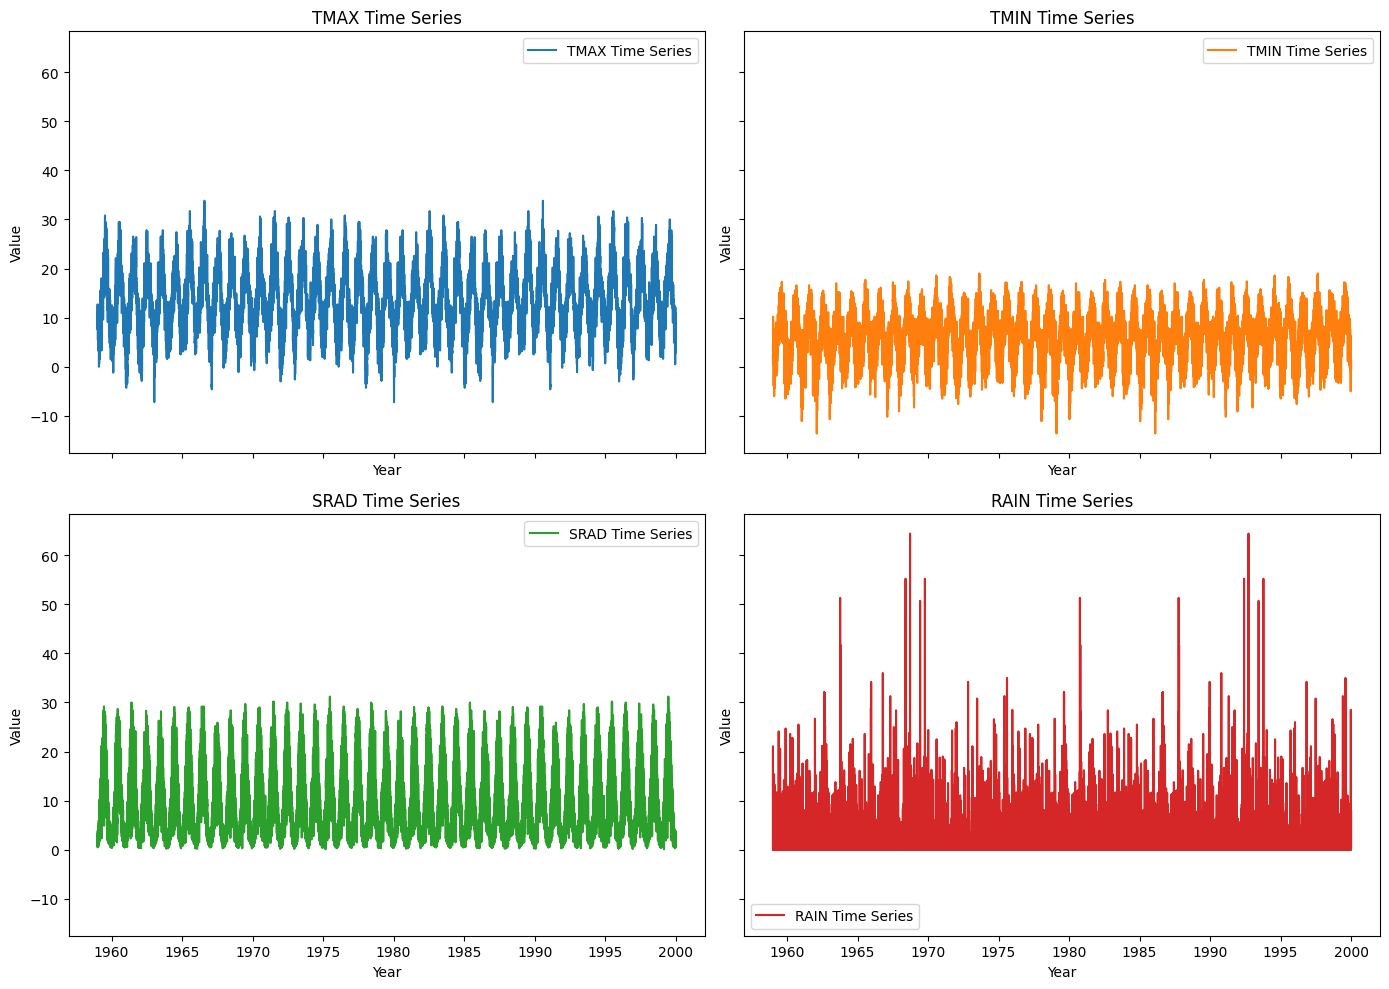

In [12]:
# List of column names to plot
column_names = ['TMAX', 'TMIN', 'SRAD', 'RAIN']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
# 'sharex=True' and 'sharey=True' mean that the x and y axes will be shared among subplots

# Loop through each column and plot the time series data
for i, column_name in enumerate(column_names):
    row = i // 2  # Determine the row index (0 or 1) in the 2x2 grid
    col = i % 2   # Determine the column index (0 or 1) in the 2x2 grid

    # Plot the data for the current column
    axs[row, col].plot(data.index, data[column_name], label=f'{
                       column_name} Time Series', color=sns.color_palette()[i])
    # Set the title for the subplot
    axs[row, col].set_title(f'{column_name} Time Series')
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout to prevent overlap of subplot elements
plt.tight_layout()
# Display the plot
plt.show()

## Stationary Test

In [13]:
# List of column names to test for stationarity
column_names = ['TMAX', 'TMIN', 'SRAD', 'RAIN']

# Loop through each column to perform the ADF test
for col in column_names:
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(data[col])

    # Print the results for the current column
    print(f"Results for column: {col}")
    print(f"ADF Statistic: {result[0]}")  # Test statistic
    print(f"p-value: {result[1]}")  # p-value of the test
    print("Critical Values:")
    # Print critical values for different confidence levels
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    # Interpretation based on p-value
    if result[1] <= 0.05:
        print(f"The {col} column is stationary (reject the null hypothesis)")
    else:
        print(
            f"The {col} column is not stationary (fail to reject the null hypothesis)")

    print()  # Print an empty line for better readability between results



Results for column: TMAX
ADF Statistic: -8.253416111938003
p-value: 5.315439555906522e-13
Critical Values:
	1%: -3.4307879846275897
	5%: -2.86173357019438
	10%: -2.5668730327534237
The TMAX column is stationary (reject the null hypothesis)

Results for column: TMIN
ADF Statistic: -8.138687706528392
p-value: 1.0422913663600965e-12
Critical Values:
	1%: -3.430787955294528
	5%: -2.8617335572313958
	10%: -2.5668730258533734
The TMIN column is stationary (reject the null hypothesis)

Results for column: SRAD
ADF Statistic: -8.249830727985843
p-value: 5.428587027788952e-13
Critical Values:
	1%: -3.430788013964581
	5%: -2.8617335831591
	10%: -2.566873039654398
The SRAD column is stationary (reject the null hypothesis)

Results for column: RAIN
ADF Statistic: -22.607744178975636
p-value: 0.0
Critical Values:
	1%: -3.4307876036040046
	5%: -2.8617334018109024
	10%: -2.5668729431248
The RAIN column is stationary (reject the null hypothesis)



## Visualization to prove stationary

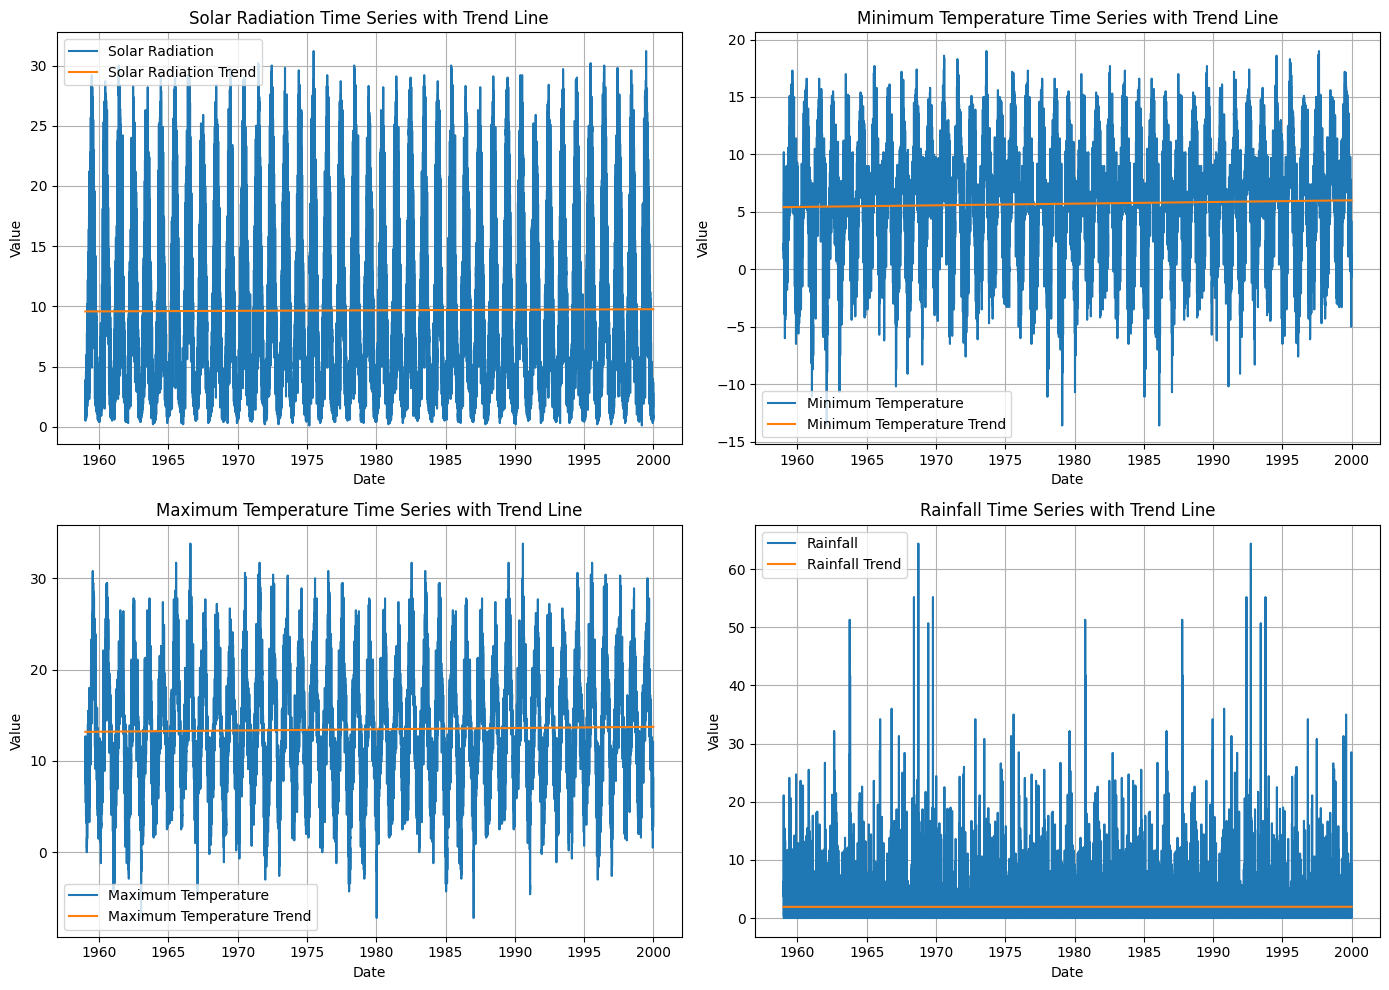

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# List of columns to plot
columns = ['SRAD', 'TMIN', 'TMAX', 'RAIN']
titles = ['Solar Radiation', 'Minimum Temperature', 'Maximum Temperature', 'Rainfall']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Loop through each column and plot the time series and trend line
for i, column in enumerate(columns):
    row = i // 2  # Determine the row index (0 or 1)
    col = i % 2   # Determine the column index (0 or 1)
    
    # Plot the original time series
    axs[row, col].plot(data.index, data[column], label=f'{titles[i]}')
    
    # Calculate and plot the trend line
    z = np.polyfit(data.index.map(lambda x: x.toordinal()), data[column], 1)
    p = np.poly1d(z)
    axs[row, col].plot(data.index, p(data.index.map(lambda x: x.toordinal())), linestyle='-', label=f'{titles[i]} Trend')
    
    # Customize the subplot
    axs[row, col].set_title(f'{titles[i]} Time Series with Trend Line')
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()
    axs[row, col].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Detecting outliers and Manage them

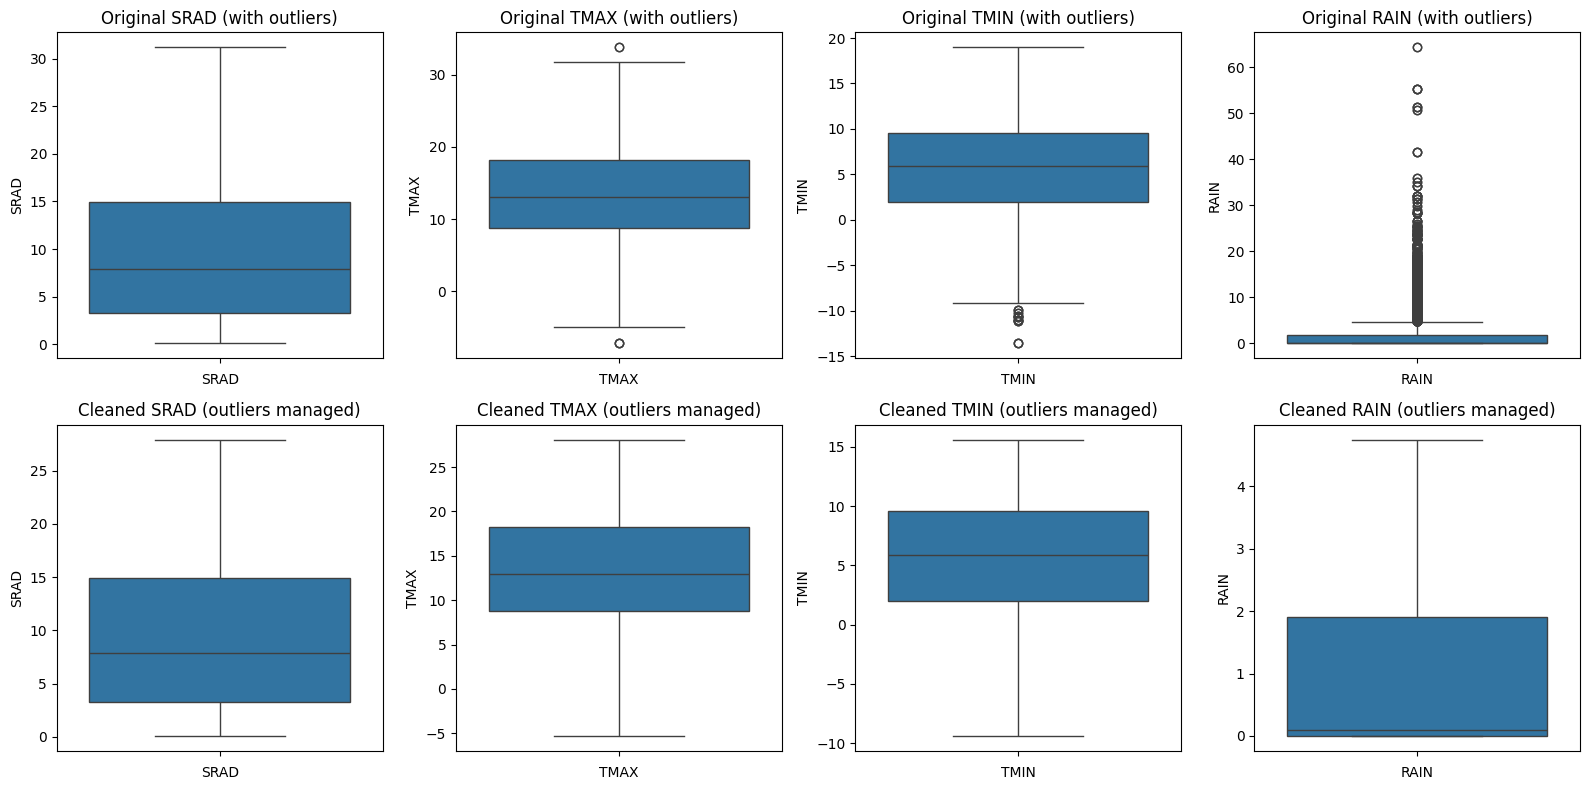

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def outlier_detection_iqr(data, columns, k=1.5, method='cap'):
    # Make a copy of the input data to avoid modifying the original DataFrame
    data = data.copy()

    def calculate_bounds(column_data, k):
        """Calculate IQR bounds for a given column."""
        q1 = column_data.quantile(0.25)
        q3 = column_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr

        # Adjust upper_bound to a dynamic value (e.g., 99th percentile)
        dynamic_upper_bound = column_data.quantile(0.99)
        upper_bound = min(upper_bound, dynamic_upper_bound)

        return lower_bound, upper_bound

    for column in columns:
        lower_bound, upper_bound = calculate_bounds(data[column], k)

        if method == 'remove':
            data = data[(data[column] >= lower_bound) &
                        (data[column] <= upper_bound)]
        elif method == 'cap':
            data[column] = data[column].clip(
                lower=lower_bound, upper=upper_bound)
        elif method == 'transform':
            data[column] = data[column].apply(lambda x: lower_bound if x < lower_bound else (
                upper_bound if x > upper_bound else x))

    return data

# List of columns to check for outliers
columns_to_check = ['SRAD', 'TMAX', 'TMIN', 'RAIN']

# Apply outlier handling function
cleaned_data = outlier_detection_iqr(data, columns_to_check, method='cap')

# Create a figure with subplots arranged in a 2x4 grid
fig, axs = plt.subplots(2, len(columns_to_check), figsize=(16, 8))

# Plot original data with outliers
for i, column in enumerate(columns_to_check):
    sns.boxplot(data=data[column], ax=axs[0, i])
    axs[0, i].set_title(f'Original {column} (with outliers)')
    axs[0, i].set_xlabel(column)

# Plot cleaned data after outlier management
for i, column in enumerate(columns_to_check):
    sns.boxplot(data=cleaned_data[column], ax=axs[1, i])
    axs[1, i].set_title(f'Cleaned {column} (outliers managed)')
    axs[1, i].set_xlabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [16]:
data = cleaned_data
print(data.columns)

Index(['SRAD', 'TMAX', 'TMIN', 'RAIN'], dtype='object')


In [17]:
# Print the first 5 rows of the updated DataFrame to verify the changes
data.head(5)
data.describe()

,SRAD,TMAX,TMIN,RAIN
count,14975.000000,14975.000000,14975.000000,14975.000000
mean,9.658110,13.445329,5.700073,1.181439
std,7.316424,6.459637,5.030037,1.763196
min,0.100000,-5.300000,-9.400000,0.000000
25%,3.300000,8.800000,2.000000,0.000000
50%,7.900000,13.000000,5.900000,0.100000
75%,14.900000,18.200000,9.600000,1.900000
max,27.900000,28.100000,15.600000,4.750000


## Normalization

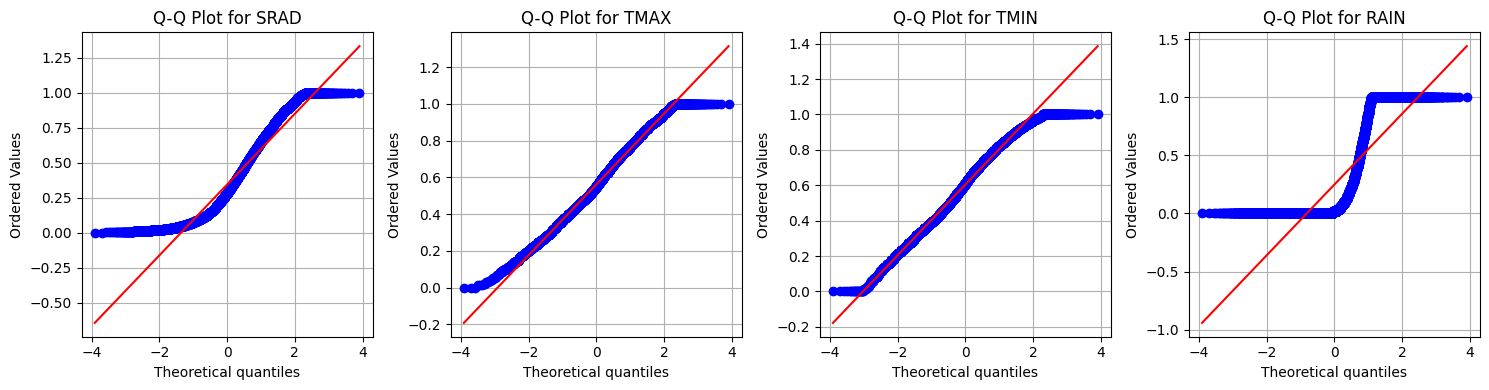

In [18]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of columns to normalize using MinMaxScaler
columns_to_normalize = [
    'SRAD', 'TMAX', 'TMIN', 'RAIN'
]

# Apply MinMax scaling to the specified columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Convert the normalized data to a NumPy array for plotting
data_to_plot = data[columns_to_normalize].to_numpy()

# Number of columns to display per row
plots_per_row = 4
# Calculate the number of rows needed
num_rows = int(np.ceil(len(columns_to_normalize) / plots_per_row))

# Create a figure with subplots arranged in rows and columns
fig, axes = plt.subplots(num_rows, plots_per_row,
                         figsize=(15, 4 * num_rows), squeeze=False)

# Loop through each column to create a Q-Q plot
for i, col in enumerate(columns_to_normalize):
    row = i // plots_per_row
    col_idx = i % plots_per_row
    ax = axes[row, col_idx]

    # Create a Q-Q plot comparing the data to a normal distribution
    stats.probplot(data_to_plot[:, i], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot for {col}')
    ax.grid(True)

# Hide any unused subplots (if there are fewer columns than plots_per_row * num_rows)
for j in range(len(columns_to_normalize), num_rows * plots_per_row):
    fig.delaxes(axes.flatten()[j])

# Adjust the layout of subplots to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


## Feature Engineering to Predict Maximun Tempreture

In [19]:
# Shift the 'SRAD', 'TMAX', 'TMIN', and 'RAIN' columns by 7 days to create new features for the previous week
data['PWEEK_SRAD'] = data['SRAD'].shift(7)
data['PWEEK_TMAX'] = data['TMAX'].shift(7)
data['PWEEK_TMIN'] = data['TMIN'].shift(7)
data['PWEEK_RAIN'] = data['RAIN'].shift(7)

# Drop rows with NaN values
data.dropna(inplace=True)

In [20]:
#add new features
data['PWEEK_TMAX_MIN'] = data['TMAX'].rolling(
    window=7, min_periods=1).min()
data['PWEEK_TMAX_MAX'] = data['TMAX'].rolling(
    window=7, min_periods=1).max()
data['PWEEK_TMAX_MEAN'] = data['TMAX'].rolling(
    window=7, min_periods=1).mean()
data['PWEEK_TMIN_MEAN'] = data['TMIN'].rolling(
    window=7, min_periods=1).mean()

In [56]:
# Resampling data to monthly averages - trying to make it easier to see. 
monthly_data = data.resample('M').mean()

In [57]:

# Extract the month from the datetime index
monthly_data['month'] = monthly_data.index.month

# Define a function to map each month to its corresponding season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'   # December, January, February are Winter
    elif month in [3, 4, 5]:
        return 'Spring'   # March, April, May are Spring
    elif month in [6, 7, 8]:
        return 'Summer'   # June, July, August are Summer
    elif month in [9, 10, 11]:
        return 'Fall'     # September, October, November are Fall

# Apply the season mapping function to the 'month' column and create a new 'season' column
monthly_data['season'] = monthly_data['month'].apply(get_season)

# Display the first few rows to verify the result
print(monthly_data[['month', 'season']].head())

            month  season
@DATE                    
1959-01-31      1  Winter
1959-02-28      2  Winter
1959-03-31      3  Spring
1959-04-30      4  Spring
1959-05-31      5  Spring


## Confussin Matrix

                     SRAD      TMAX      TMIN      RAIN  PWEEK_SRAD  \
SRAD             1.000000  0.709977  0.410115 -0.262857    0.675816   
TMAX             0.709977  1.000000  0.822800 -0.082120    0.655523   
TMIN             0.410115  0.822800  1.000000  0.010338    0.530421   
RAIN            -0.262857 -0.082120  0.010338  1.000000   -0.088319   
PWEEK_SRAD       0.675816  0.655523  0.530421 -0.088319    1.000000   
PWEEK_TMAX       0.572298  0.774605  0.705375 -0.064818    0.709944   
PWEEK_TMIN       0.445337  0.669535  0.637401 -0.047668    0.410061   
PWEEK_RAIN      -0.088330 -0.083755 -0.056827  0.085931   -0.262854   
PWEEK_TMAX_MIN   0.639870  0.903072  0.822085 -0.070256    0.672929   
PWEEK_TMAX_MAX   0.670922  0.902574  0.804521 -0.077971    0.706405   
PWEEK_TMAX_MEAN  0.661652  0.918702  0.834373 -0.073776    0.699462   
PWEEK_TMIN_MEAN  0.521036  0.832215  0.854224 -0.037499    0.576897   

                 PWEEK_TMAX  PWEEK_TMIN  PWEEK_RAIN  PWEEK_TMAX_MIN  \
SRAD 

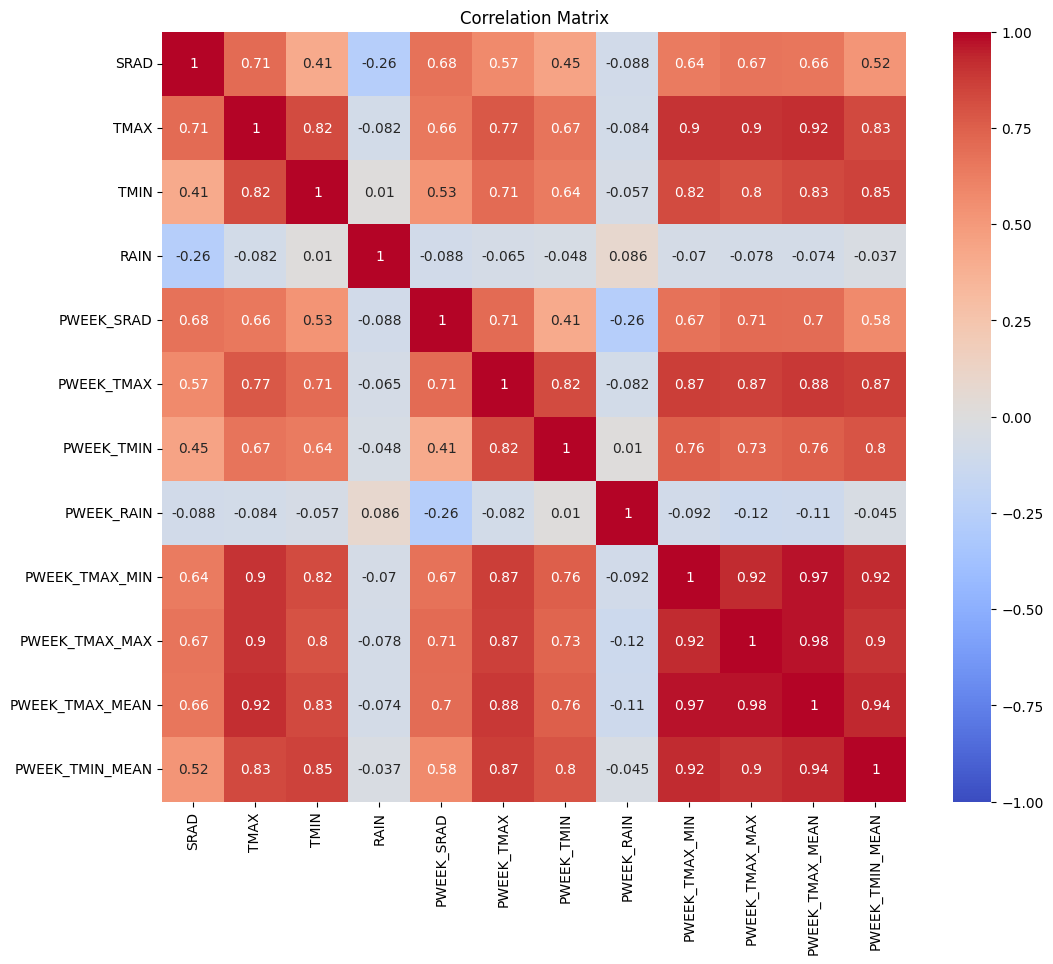

In [27]:
corr_matrix = data.corr()
print(corr_matrix)

#visualization setting
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Implement

## Spilitting dataset

In [44]:
#target and predictors features
x_tmaximum = data[['PWEEK_TMAX', 'PWEEK_SRAD', 'PWEEK_TMIN',
                   'PWEEK_TMAX_MIN', 'PWEEK_TMAX_MAX']]
y_tmaximum = data['TMAX']

#data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_tmaximum)

In [45]:
#split dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_tmaximum, test_size=0.2, random_state=42)

# Short term prediction for Maximun Tempreture

## Implementation of three Regression Models(MLR,SVR,RF)

In [46]:
warnings.filterwarnings("ignore")

# Define and fit models
# Model 1: RandomForestRegressor
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Model 2: Support Vector Regression
svr = SVR(kernel='rbf', C=10, gamma='auto', epsilon=0.1)
svr.fit(X_train, y_train)

# Model 3: Linear Regression
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

# Define k-folds for cross-validation
k = 10

# Initialize metrics dictionary to store results
metrics = {}

# Evaluate the models with Cross-Validation
models = {
    'RandomForestRegressor': (best_rf, 'neg_mean_squared_error'),
    'Support Vector Regression': (svr, 'neg_mean_squared_error'),
    'Linear Regression': (mlr_model, 'neg_mean_squared_error')
}

for name, (model, scoring) in models.items():
    cv_results = cross_validate(model, X_train, y_train, cv=k, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
    y_pred = model.predict(X_test)
    
    mse = -cv_results['test_neg_mean_squared_error'].mean()
    mae = -cv_results['test_neg_mean_absolute_error'].mean()
    r2 = cv_results['test_r2'].mean()
    rrmse = np.sqrt(mse) / np.mean(y_test)
    
    metrics[name] = {
        'MSE': mse,
        'MAE': mae,
        'R^2': r2,
        'RRMSE': rrmse
    }

# Print metrics for all models
for name, metric in metrics.items():
    rrmse = metric['RRMSE']
    
    # Check the RRMSE value and assign a quality label
    if rrmse < 0.1:
        quality = "Well"
    elif 0.1 <= rrmse < 0.3:
        quality = "Fair"
    else:
        quality = "Need to Improve"
    
    # Print the RRMSE value with its corresponding quality label
    print(f"{name} - RRMSE: {rrmse:.4f} ({quality})\n")
    
    print(f"{name} - Cross-Validated Mean Squared Error (MSE): {metric['MSE']:.4f}")
    print(f"{name} - Cross-Validated Mean Absolute Error (MAE): {metric['MAE']:.4f}")
    print(f"{name} - Cross-Validated R^2: {metric['R^2']:.4f}")
    print(f"{name} - RRMSE on Test Data: {metric['RRMSE']:.4f}\n")



RandomForestRegressor - RRMSE: 0.0668 (Well)

RandomForestRegressor - Cross-Validated Mean Squared Error (MSE): 0.0014
RandomForestRegressor - Cross-Validated Mean Absolute Error (MAE): 0.0252
RandomForestRegressor - Cross-Validated R^2: 0.9629
RandomForestRegressor - RRMSE on Test Data: 0.0668

Support Vector Regression - RRMSE: 0.1301 (Fair)

Support Vector Regression - Cross-Validated Mean Squared Error (MSE): 0.0053
Support Vector Regression - Cross-Validated Mean Absolute Error (MAE): 0.0611
Support Vector Regression - Cross-Validated R^2: 0.8595
Support Vector Regression - RRMSE on Test Data: 0.1301

Linear Regression - RRMSE: 0.1308 (Fair)

Linear Regression - Cross-Validated Mean Squared Error (MSE): 0.0053
Linear Regression - Cross-Validated Mean Absolute Error (MAE): 0.0605
Linear Regression - Cross-Validated R^2: 0.8580
Linear Regression - RRMSE on Test Data: 0.1308



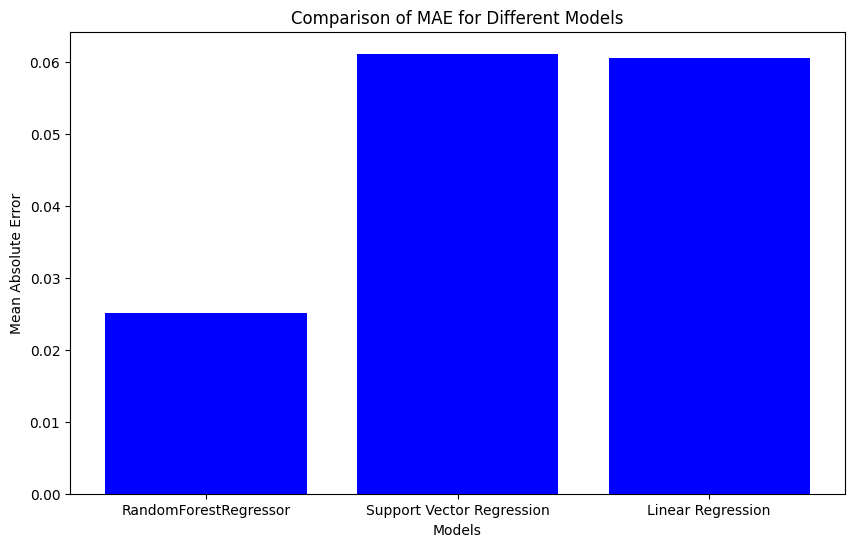

In [47]:
# Plot comparison of MAE for Different Models
mae_values = {name: metric['MAE'] for name, metric in metrics.items()}

plt.figure(figsize=(10, 6))
plt.bar(mae_values.keys(), mae_values.values(), color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of MAE for Different Models')
plt.show()


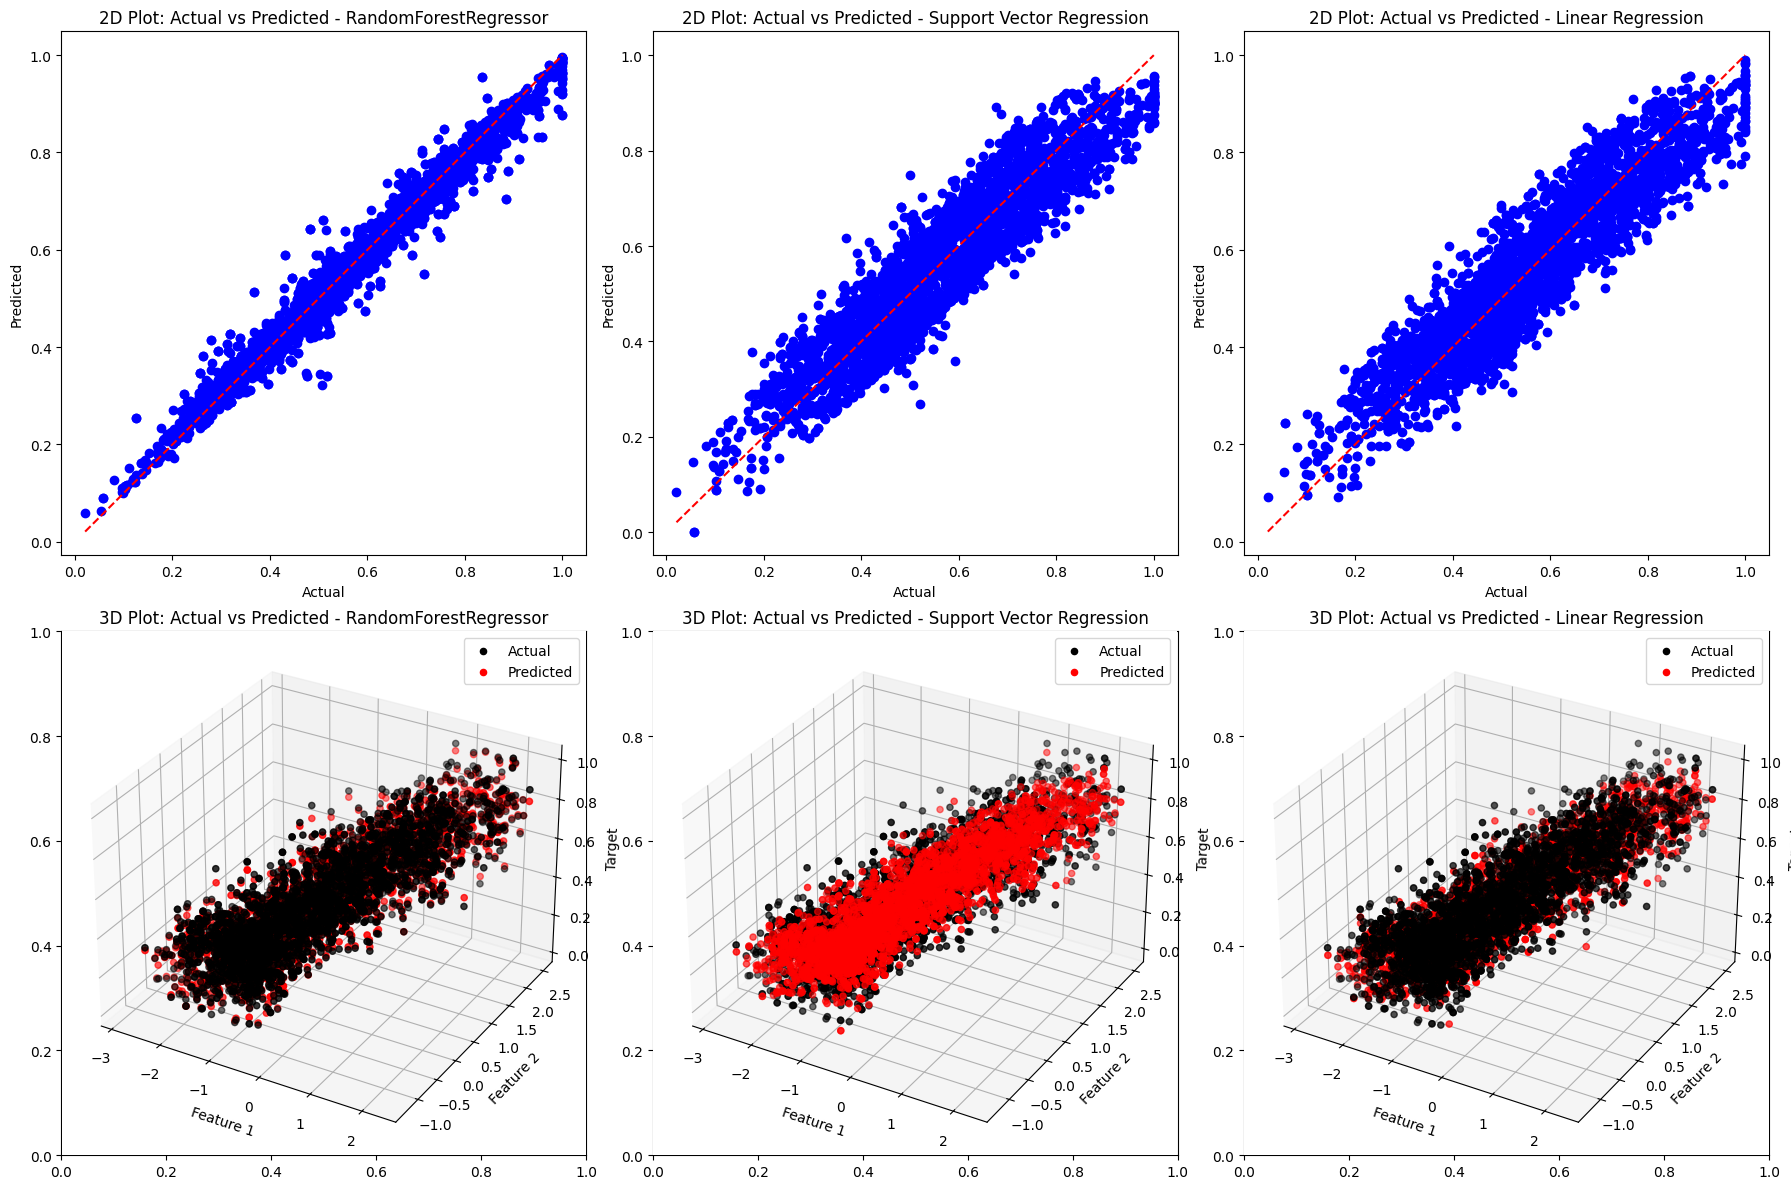

In [48]:
# Ensure predictions are in correct shape
y_test = np.array(y_test).ravel()  # Flatten y_test just in case

fig, axes = plt.subplots(nrows=2, ncols=len(models), figsize=(18, 12))

# Predict for each model and plot
for i, (name, (model, _)) in enumerate(models.items()):
    y_pred = model.predict(X_test).ravel()  # Get predictions and ensure they are flat

    # Check if the length of y_test and y_pred match
    if y_test.shape[0] != y_pred.shape[0]:
        raise ValueError(f"Shape mismatch: y_test has shape {y_test.shape}, but y_pred for model {name} has shape {y_pred.shape}")

    # 2D Plot - Actual vs Predicted
    axes[0, i].scatter(y_test, y_pred, color='blue')
    axes[0, i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    axes[0, i].set_xlabel('Actual')
    axes[0, i].set_ylabel('Predicted')
    axes[0, i].set_title(f'2D Plot: Actual vs Predicted - {name}')

    # 3D Plot - Actual vs Predicted (only if enough features)
    if X_test.shape[1] >= 2:
        ax = fig.add_subplot(2, len(models), len(models) + i + 1, projection='3d')
        ax.scatter(X_test[:, 0], X_test[:, 1], y_test, color='black', label='Actual')
        ax.scatter(X_test[:, 0], X_test[:, 1], y_pred, color='red', label='Predicted')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Target')
        ax.set_title(f'3D Plot: Actual vs Predicted - {name}')
        ax.legend()

plt.tight_layout()
plt.show()


## Implementation of Convolutional Neural Networks(CNN)

In [49]:
# Convert to 3D array for use in CNN model
X_scaled = np.expand_dims(x_tmaximum, axis=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_tmaximum, test_size=0.2, random_state=42)

# Convert target arrays to numpy arrays
y_train = y_train.values
y_test = y_test.values
# Build the CNN model

In [50]:

# Initialize lists to store metrics for each fold
mse_list, mae_list, r2_list, rrmse_list = [], [], [], []

# Define the KFold cross-validator with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation loop
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_tmaximum.values[train_index], y_tmaximum.values[test_index]
    
    # Build the CNN model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Predict on the test set
    y_pred = model.predict(X_test).flatten()  # Flatten predictions to match y_test shape
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rrmse = np.sqrt(mse) / np.mean(y_test)
    
    # Append metrics to the respective lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    rrmse_list.append(rrmse)
    
    # Clear the session and collect garbage to avoid memory issues
    K.clear_session()
    gc.collect()

# Calculate and print the mean of each metric across all folds
print(f'Mean Squared Error (MSE): {np.mean(mse_list):.4f}')
print(f'Mean Absolute Error (MAE): {np.mean(mae_list):.4f}')
print(f'R^2: {np.mean(r2_list):.4f}')
print(f'RRMSE: {np.mean(rrmse_list):.4f}')





47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.0052
Mean Absolute Error (MAE): 0.0594
R^2: 0.8618
RRMSE: 0.1280


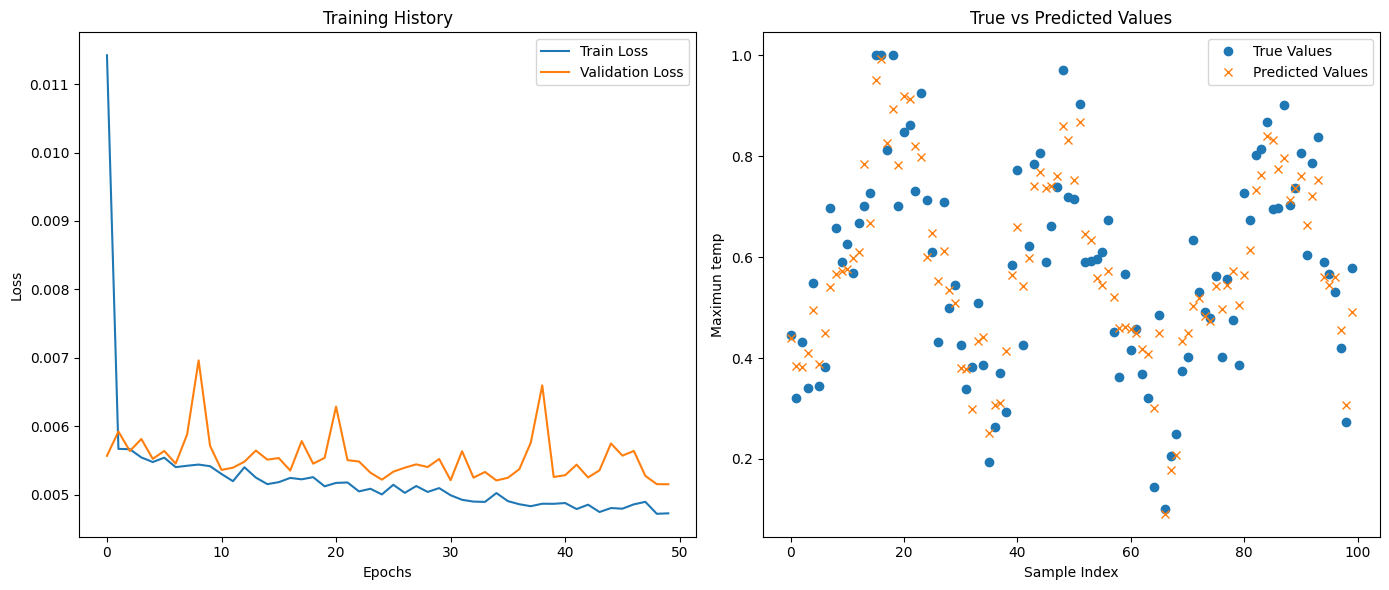

In [95]:


# Plot training history
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot actual vs predicted values
plt.subplot(1, 2, 2)
plt.plot(y_test[:100], label='True Values', marker='o', linestyle='')
plt.plot(y_pred[:100], label='Predicted Values', marker='x', linestyle='')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Maximun temp')
plt.legend()
plt.tight_layout()
plt.show()


# Long term prediction for Maximum Tempreture

## Utilizing ARIMAX to predict maximum Tempreture

Best ARIMAX(0, 0, 0) RMSE=0.07205980583859993
Final Mean Absolute Error (MAE): 0.05877118448284974
Mean Squared Error (MSE): 0.00519261561749672
Root Mean Squared Error (RMSE): 0.07205980583859993
R^2 Score: 0.8620876729738793
Relative Root Mean Squared Error (RRMSE): 0.1282571071629598
ARIMAX model predictions with errors saved to C:/Users/pc_parsian/Downloads/weather data 4/weather data/csv_files\arimax_predictions_with_errors.csv


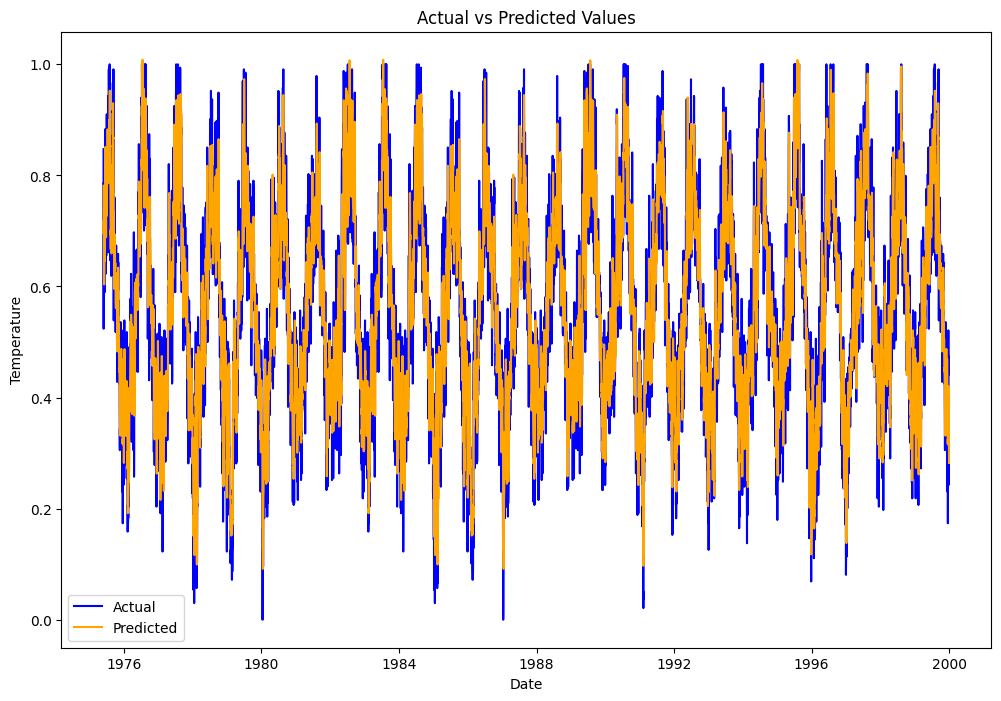

In [38]:
warnings.filterwarnings("ignore")
# Define features and target
x_tmaximum = data[['PWEEK_TMAX', 'PWEEK_SRAD', 'PWEEK_TMIN', 
                   'PWEEK_TMAX_MIN', 'PWEEK_TMAX_MAX', 
                   'PWEEK_TMAX_MEAN', 'PWEEK_TMIN_MEAN']]
y_tmaximum = data['TMAX']

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_x, test_x = x_tmaximum[:train_size], x_tmaximum[train_size:]
train_y, test_y = y_tmaximum[:train_size], y_tmaximum[train_size:]

# Define the grid search parameters
p = range(0, 3)  # AR parameters
d = range(0, 2)  # Differencing parameters
q = range(0, 3)  # MA parameters
pdq = list(itertools.product(p, d, q))

# Grid search to find the best parameters
best_score, best_params = float("inf"), None
for param in pdq:
    try:
        model = ARIMA(train_y, exog=train_x, order=param)
        results = model.fit()
        
        # Prediction for evaluation
        forecast = results.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_x)
        
        # Model evaluation
        mae = mean_absolute_error(test_y, forecast)
        rmse = np.sqrt(mean_squared_error(test_y, forecast))
        score = rmse  # You can also use MAE or AIC as the metric
        
        if score < best_score:
            best_score = score
            best_params = param
    except Exception as e:
        print(f"Error with parameters {param}: {e}")
        continue

print(f'Best ARIMAX{best_params} RMSE={best_score}')

# Build and fit the best ARIMAX model with the best parameters
best_model = ARIMA(train_y, exog=train_x, order=best_params)
best_model_fit = best_model.fit()

# Forecast with the best model
forecast = best_model_fit.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_x)

# Model evaluation
mae = mean_absolute_error(test_y, forecast)
mse = mean_squared_error(test_y, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, forecast)
rrmse = rmse / np.mean(test_y)

print(f'Final Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')
print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')
})


print(f'ARIMAX model predictions with errors saved to {results_output_file_path}')
# Result visualization
plt.figure(figsize=(12, 8))
plt.plot(test_y.index, test_y, label='Actual', color='blue')
plt.plot(test_y.index, forecast, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Feature Engineering to predict Rainfall

In [21]:

# 1. Calculate the exponentially weighted mean rainfall over the previous week
# This gives more weight to recent days compared to earlier days in the week
data['rain_ewm_mean_for_7_days'] = data['RAIN'].ewm(span=7, adjust=False).mean()

# 2. Calculate the standard deviation of rainfall over the previous week
# Rolling window of 7 days with a minimum of 1 period, calculates the std deviation
data['rain_std'] = data['RAIN'].rolling(window=3, min_periods=1).std()

# 3. Calculate the maximum rainfall over the previous week
# Rolling window of 7 days with a minimum of 1 period, calculates the max value
data['rain_max'] = data['RAIN'].rolling(window=3, min_periods=1).max()

# 4. Calculate the minimum rainfall over the previous week
# Rolling window of 7 days with a minimum of 1 period, calculates the min value
data['rain_min'] = data['RAIN'].rolling(window=3, min_periods=1).min()

# 5. Calculate the total rainfall over the last 3 days
# Rolling window of 3 days with a minimum of 1 period, calculates the sum of rainfall
data['RAIN_LAST_3DAYS'] = data['RAIN'].rolling(window=3, min_periods=1).sum()

# 6. Calculate the average rainfall over the last 3 days
# Rolling window of 3 days with a minimum of 1 period, calculates the mean of rainfall
data['RAIN_LAST_3DAYS_mean'] = data['RAIN'].rolling(window=3, min_periods=1).mean()

# 7. Calculate the total rainfall over the last 10 days
# Rolling window of 10 days with a minimum of 1 period, calculates the sum of rainfall
data['RAIN_LAST_10DAYS'] = data['RAIN'].rolling(window=10, min_periods=1).sum()

# 8. Calculate the average rainfall over the last 10 days
# Rolling window of 10 days with a minimum of 1 period, calculates the mean of rainfall
data['RAIN_LAST_10DAYS_mean'] = data['RAIN'].rolling(window=10, min_periods=1).mean()

# 9. Calculate the exponentially weighted mean rainfall over the last 10 days
# Similar to the previous EWM, but with a longer span of 10 days
data['RAIN_LAST_10DAYS_Mean'] = data['RAIN'].ewm(span=10, adjust=False).mean()

# 10. Calculate the exponentially weighted mean rainfall over the last 3 days
# EWM for the last 3 days, similar to step 1 but with a shorter span
data['rain_ewm_mean_for_3_days'] = data['RAIN'].ewm(span=3, adjust=False).mean()

# 11. Calculate the exponentially weighted mean rainfall over the last 2 days
# EWM for the last 2 days, giving the most weight to the most recent day
data['rain_ewm_mean_for_2_days'] = data['RAIN'].ewm(span=2, adjust=False).mean()

# Display the first few rows of the DataFrame to verify the new features
print(data.head())

                SRAD      TMAX   TMIN      RAIN  PWEEK_SRAD  PWEEK_TMAX  \
@DATE                                                                     
1959-01-08  0.136691  0.425150  0.440  0.000000    0.028777    0.443114   
1959-01-09  0.082734  0.467066  0.456  0.042105    0.115108    0.473054   
1959-01-10  0.050360  0.479042  0.488  0.042105    0.021583    0.500000   
1959-01-11  0.075540  0.419162  0.644  0.000000    0.107914    0.526946   
1959-01-12  0.050360  0.446108  0.584  0.842105    0.028777    0.538922   

            PWEEK_TMIN  PWEEK_RAIN  PWEEK_TMAX_MIN  PWEEK_TMAX_MAX  ...  \
@DATE                                                               ...   
1959-01-08       0.464    0.105263        0.425150        0.425150  ...   
1959-01-09       0.416    0.210526        0.425150        0.467066  ...   
1959-01-10       0.412    1.000000        0.425150        0.479042  ...   
1959-01-11       0.724    0.778947        0.419162        0.479042  ...   
1959-01-12       0.576  

## Making Confusion Matrix for rainfall features

                              RAIN  rain_ewm_mean_for_2_days  \
RAIN                      1.000000                  0.948286   
rain_ewm_mean_for_2_days  0.948286                  1.000000   
rain_ewm_mean_for_3_days  0.879585                  0.982128   
RAIN_LAST_10DAYS_Mean     0.617631                  0.773754   
RAIN_LAST_10DAYS_mean     0.421972                  0.561515   
RAIN_LAST_3DAYS_mean      0.685581                  0.865991   
RAIN_LAST_3DAYS           0.685580                  0.865991   
rain_min                  0.447510                  0.558464   
rain_max                  0.631518                  0.784743   
rain_std                  0.497509                  0.615540   
rain_ewm_mean_for_7_days  0.696609                  0.851122   

                          rain_ewm_mean_for_3_days  RAIN_LAST_10DAYS_Mean  \
RAIN                                      0.879585               0.617631   
rain_ewm_mean_for_2_days                  0.982128               0.773754   


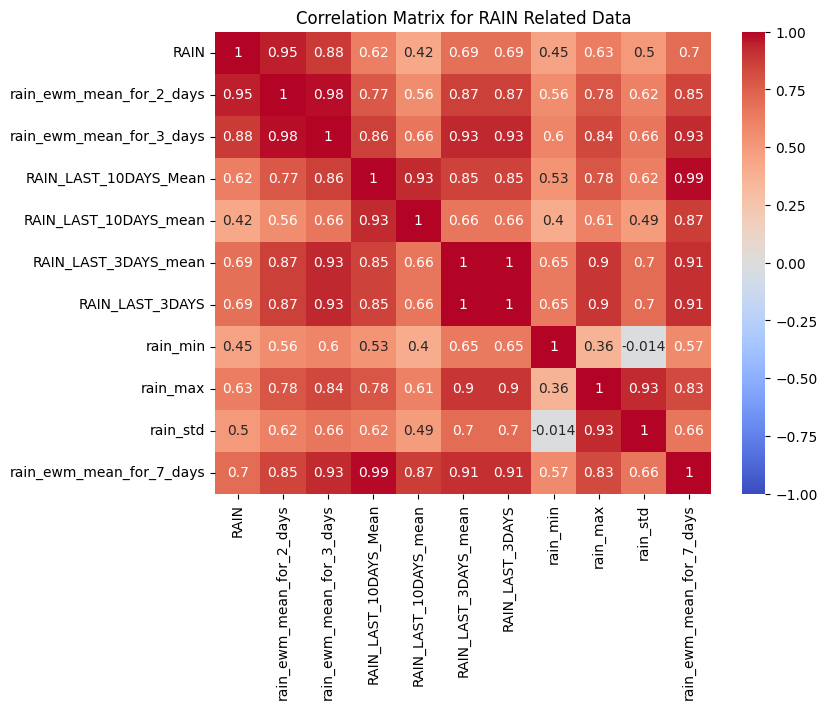

In [22]:
# Select columns related to RAIN
rain_related_columns = ['RAIN','rain_ewm_mean_for_2_days','rain_ewm_mean_for_3_days','RAIN_LAST_10DAYS_Mean','RAIN_LAST_10DAYS_mean','RAIN_LAST_3DAYS_mean','RAIN_LAST_3DAYS','rain_min',
                       'rain_max','rain_std','rain_ewm_mean_for_7_days']

# Extract data related to these columns
rain_data = data[rain_related_columns]

# Calculate the correlation matrix for the RAIN-related data
corr_matrix_rain = rain_data.corr()

# Display the correlation matrix
print(corr_matrix_rain)

# Visualization settings for the correlation matrix
plt.figure(figsize=(8, 6))  # Set the size of the figure
sns.heatmap(corr_matrix_rain, annot=True, cmap='coolwarm', vmin=-1, vmax=1)  # Create a heatmap with annotations
plt.title('Correlation Matrix for RAIN Related Data')  # Set the title of the plot
plt.show()  # Display the plot


# Short term prediction of Rainfall

## Spilting Dataset to predict rainfall

In [24]:
from sklearn.impute import SimpleImputer
# Prepare data for training and testing
x_rain = data[[ 'rain_ewm_mean_for_3_days','rain_ewm_mean_for_7_days','rain_max','RAIN_LAST_3DAYS']]
y_rain = data['RAIN']
X_train, X_test, y_train, y_test = train_test_split(
    x_rain, y_rain, test_size=0.2, random_state=42)


## Identifiying Rainy Days

In [25]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Identify rainy and non-rainy days (binary classification)
y_binary = (y_rain > 0).astype(int)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    x_rain, y_binary, test_size=0.2, random_state=42)

# Handle missing values in the binary classification feature set
imputer = SimpleImputer(strategy='mean')
X_train_bin = imputer.fit_transform(X_train_bin)
X_test_bin = imputer.transform(X_test_bin)

# Train a Random Forest Classifier with optimized hyperparameters
classifier = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
classifier.fit(X_train_bin, y_train_bin)

# Make classification predictions
y_pred_bin = classifier.predict(X_test_bin)
print("Classification Report:")
print(classification_report(y_test_bin, y_pred_bin))

# Count and print the number of rainy and non-rainy days
num_rainy_days = np.sum(y_binary)
num_non_rainy_days = len(y_binary) - num_rainy_days
print(f"Number of rainy days: {num_rainy_days}")
print(f"Number of non-rainy days: {num_non_rainy_days}")

# Select data for rainy days
X_train_rain = X_train[y_train > 0]  # Filter training features for rainy days
y_train_rain = y_train[y_train > 0]  # Filter training target for rainy days
X_test_rain = X_test[y_test > 0]     # Filter test features for rainy days
y_test_rain = y_test[y_test > 0]     # Filter test target for rainy days



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1481
           1       0.95      0.94      0.95      1513

    accuracy                           0.95      2994
   macro avg       0.95      0.95      0.95      2994
weighted avg       0.95      0.95      0.95      2994

Number of rainy days: 7664
Number of non-rainy days: 7304


## Implementation of three Regression Models to predict rainfall(MLR,SVR,RF)

Merged Metrics (Cross-Validation and Final Evaluation):
               Model    CV_MSE    CV_MAE    CV_R^2  CV_RRMSE       MSE  \
0  Linear Regression  0.009778  0.076780  0.936347  0.208288  0.009894   
1                SVR  0.009024  0.078943  0.941254  0.200095  0.008943   
2      Random Forest  0.002276  0.025864  0.985177  0.100487  0.002238   

        MAE       R^2     RRMSE  
0  0.076884  0.935740  0.209518  
1  0.078784  0.941913  0.199201  
2  0.026315  0.985461  0.099658  


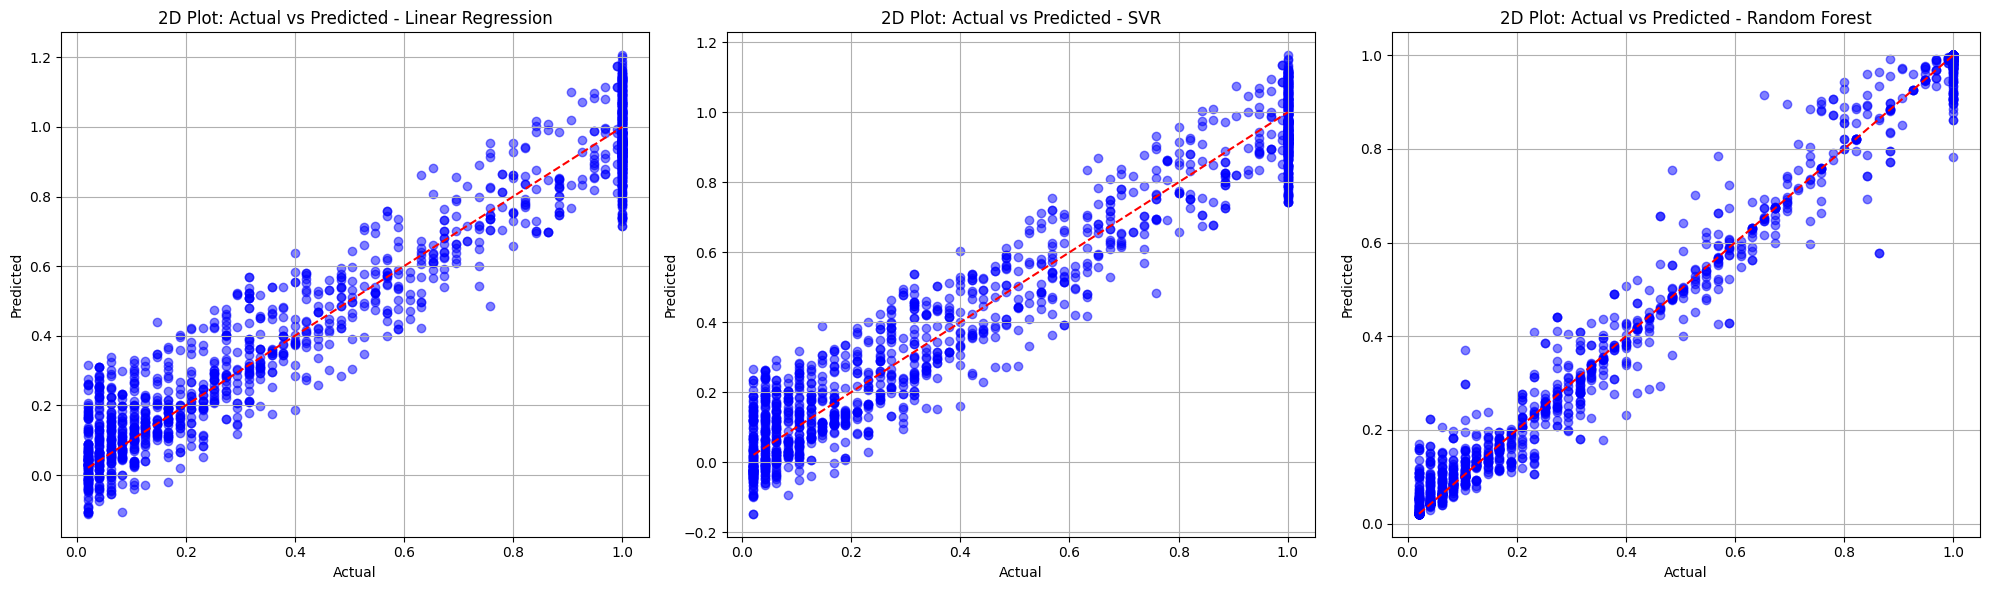

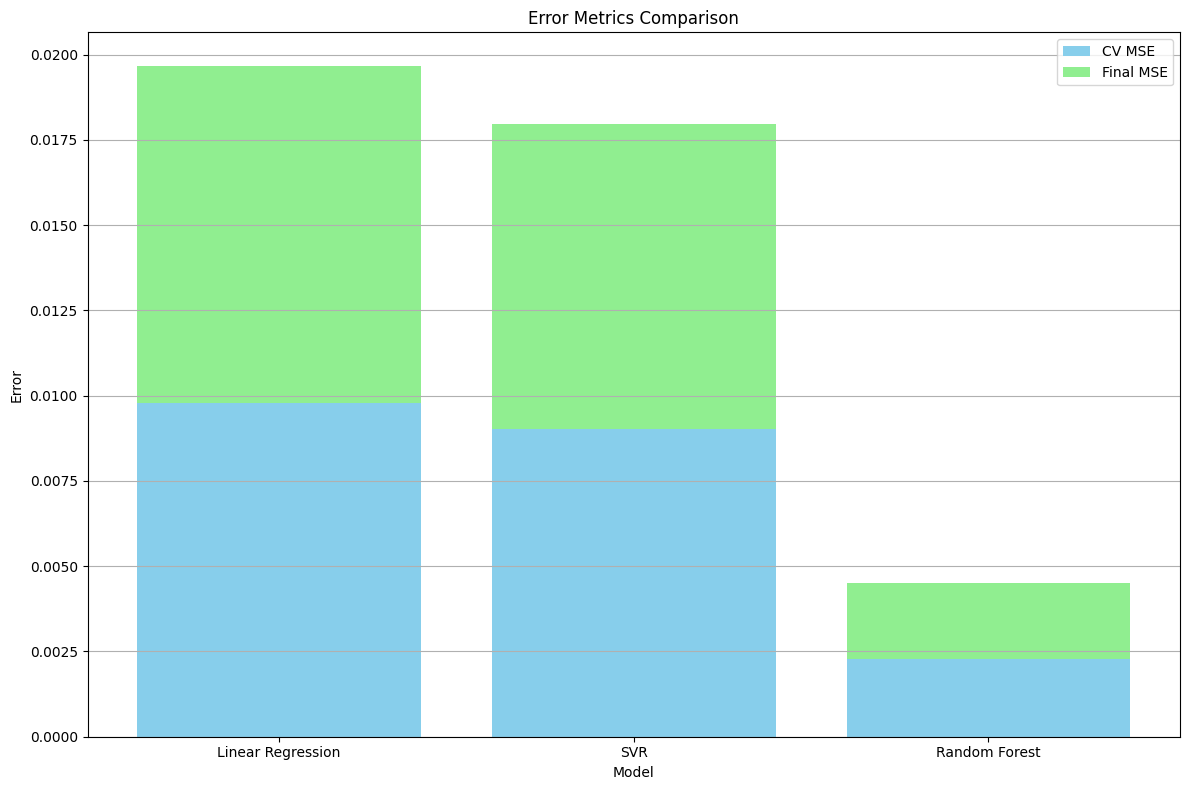

In [65]:
# Define regression models with tuned hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf', C=10, gamma='auto', epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
}

# Initialize dictionaries to store metrics for Cross-Validation and final evaluation
cv_metrics = {
    'Model': [],
    'CV_MSE': [],
    'CV_MAE': [],
    'CV_R^2': [],
    'CV_RRMSE': []
}

error_metrics = {
    'Model': [],
    'MSE': [],
    'MAE': [],
    'R^2': [],
    'RRMSE': []
}

# Define k-folds for cross-validation
k = 10

# Perform Cross-Validation and evaluate models
for model_name, model in models.items():
    # Perform Cross-Validation
    cv_results = cross_validate(model, X_train_rain, y_train_rain, cv=k,
                               scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
    
    # Calculate Cross-Validation metrics
    cv_mse = -cv_results['test_neg_mean_squared_error'].mean()
    cv_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    cv_r2 = cv_results['test_r2'].mean()
    cv_rmse = np.sqrt(cv_mse)
    cv_rrmse = cv_rmse / np.mean(y_test_rain)
    
    # Store Cross-Validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['CV_MSE'].append(cv_mse)
    cv_metrics['CV_MAE'].append(cv_mae)
    cv_metrics['CV_R^2'].append(cv_r2)
    cv_metrics['CV_RRMSE'].append(cv_rrmse)
    
    # Train the model on the full training set
    model.fit(X_train_rain, y_train_rain)
    y_pred_rain = model.predict(X_test_rain)
    
    # Calculate final evaluation metrics
    mse = mean_squared_error(y_test_rain, y_pred_rain)
    mae = mean_absolute_error(y_test_rain, y_pred_rain)
    r2 = r2_score(y_test_rain, y_pred_rain)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test_rain)
    
    # Store final evaluation metrics
    error_metrics['Model'].append(model_name)
    error_metrics['MSE'].append(mse)
    error_metrics['MAE'].append(mae)
    error_metrics['R^2'].append(r2)
    error_metrics['RRMSE'].append(rrmse)

# Convert metrics dictionaries to DataFrames
cv_metrics_df = pd.DataFrame(cv_metrics)
error_metrics_df = pd.DataFrame(error_metrics)

# Merge Cross-Validation and Error Metrics DataFrames
merged_metrics_df = pd.merge(cv_metrics_df, error_metrics_df, on='Model', suffixes=('_CV', '_Final'))

# Print the merged metrics
print("Merged Metrics (Cross-Validation and Final Evaluation):")
print(merged_metrics_df)

# Create a figure with subplots for Actual vs Predicted
fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 6))

colors = ['blue', 'orange', 'red']
linestyles = ['-', '--', '-.']

for i, (model_name, model) in enumerate(models.items()):
    # Predictions from the current model
    y_pred_rain = model.predict(X_test_rain).ravel()  # Ensure predictions are flat

    # Check if the length of y_test and y_pred match
    if len(y_test_rain) != len(y_pred_rain):
        raise ValueError(f"Shape mismatch: y_test has shape {len(y_test_rain)}, but y_pred for model {model_name} has shape {len(y_pred_rain)}")

    # 2D Plot - Actual vs Predicted
    axes[i].scatter(y_test_rain, y_pred_rain, color='blue', alpha=0.5)
    axes[i].plot([min(y_test_rain), max(y_test_rain)], [min(y_test_rain), max(y_test_rain)], color='red', linestyle='--')
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'2D Plot: Actual vs Predicted - {model_name}')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Plotting the errors for each model in a bar chart
plt.figure(figsize=(12, 8))
plt.bar(merged_metrics_df['Model'], merged_metrics_df['CV_MSE'], color='skyblue', label='CV MSE')
plt.bar(merged_metrics_df['Model'], merged_metrics_df['MSE'], color='lightgreen', bottom=merged_metrics_df['CV_MSE'], label='Final MSE')
plt.title('Error Metrics Comparison')
plt.xlabel('Model')
plt.ylabel('Error')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [37]:
# Convert to 3D array for use in CNN model
X_scaled = np.expand_dims(x_rain, axis=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_rain, test_size=0.2, random_state=42)

# Convert target arrays to numpy arrays
y_train = y_train.values
y_test = y_test.values


## Convolutional Neural Networks (CNN)to Predict Rainfall

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 2, 64)               │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          12,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,313 (216.07 KB)

 Trainable params: 55,313 (216.07 KB)

 Non-trainable params: 0 (0.00 B)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Mean Squared Error (MSE): 0.0019
Mean Absolute Error (MAE): 0.0236
R^2: 0.9862
RRMSE: 0.1723


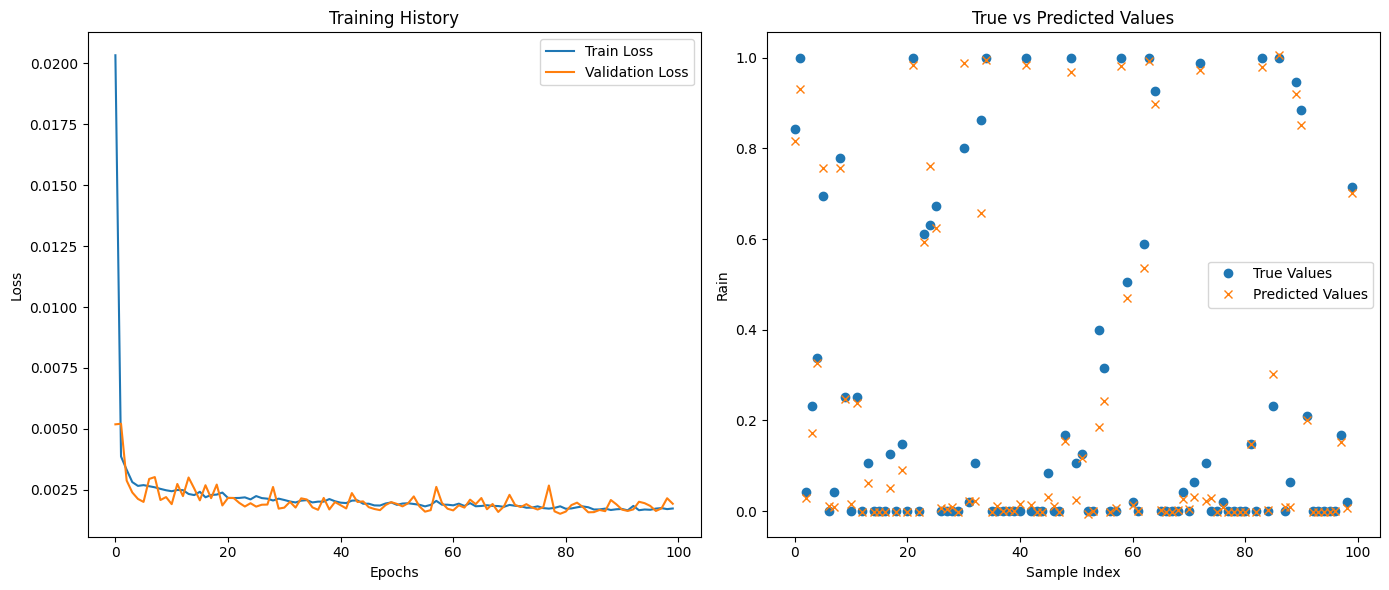

In [42]:

# Initialize lists to store metrics for each fold
mse_list, mae_list, r2_list, rrmse_list = [], [], [], []

# Define the KFold cross-validator with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation loop
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_rain.values[train_index], y_rain.values[test_index]
    

# Build the deeper CNN model
model = Sequential()

# Add CNN layers with padding='same'
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
          padding='same', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=128, kernel_size=3,
          activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Flatten())

# Add Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Display model summary
model.summary()
 # Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)
# Predict on the test set
y_pred = model.predict(X_test).flatten()  # Flatten predictions to match y_test shape
    
 # Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rrmse = np.sqrt(mse) / np.mean(y_test)
    
# Append metrics to the respective lists
mse_list.append(mse)
mae_list.append(mae)
r2_list.append(r2)
rrmse_list.append(rrmse)
    
# Clear the session and collect garbage to avoid memory issues
K.clear_session()
gc.collect()    
    

# Calculate and print the mean of each metric across all folds
print(f'Mean Squared Error (MSE): {np.mean(mse_list):.4f}')
print(f'Mean Absolute Error (MAE): {np.mean(mae_list):.4f}')
print(f'R^2: {np.mean(r2_list):.4f}')
print(f'RRMSE: {np.mean(rrmse_list):.4f}')




# Plot training history
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot actual vs predicted values
plt.subplot(1, 2, 2)
plt.plot(y_test[:100], label='True Values', marker='o', linestyle='')
plt.plot(y_pred[:100], label='Predicted Values', marker='x', linestyle='')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Rain')
plt.legend()
plt.tight_layout()
plt.show()


# Longterm Prediction of Rainfall

## Utilizing ARIMAX to predict Rainfall

Best ARIMAX(0, 0, 0) RMSE=0.08508773303456327
Final Mean Absolute Error (MAE): 0.05071416297427081
Mean Squared Error (MSE): 0.006389932914033908
Root Mean Squared Error (RMSE): 0.07993705595050338
R^2 Score: 0.9536474805618473
Relative Root Mean Squared Error (RRMSE): 0.3212549357673959
ARIMAX model predictions saved to C:/Users/pc_parsian/Downloads/weather data 4/weather data/csv_files\arimax_predictions1.csv
ARIMAX model error metrics saved to C:/Users/pc_parsian/Downloads/weather data 4/weather data/csv_files\arimax_error_metrics.csv


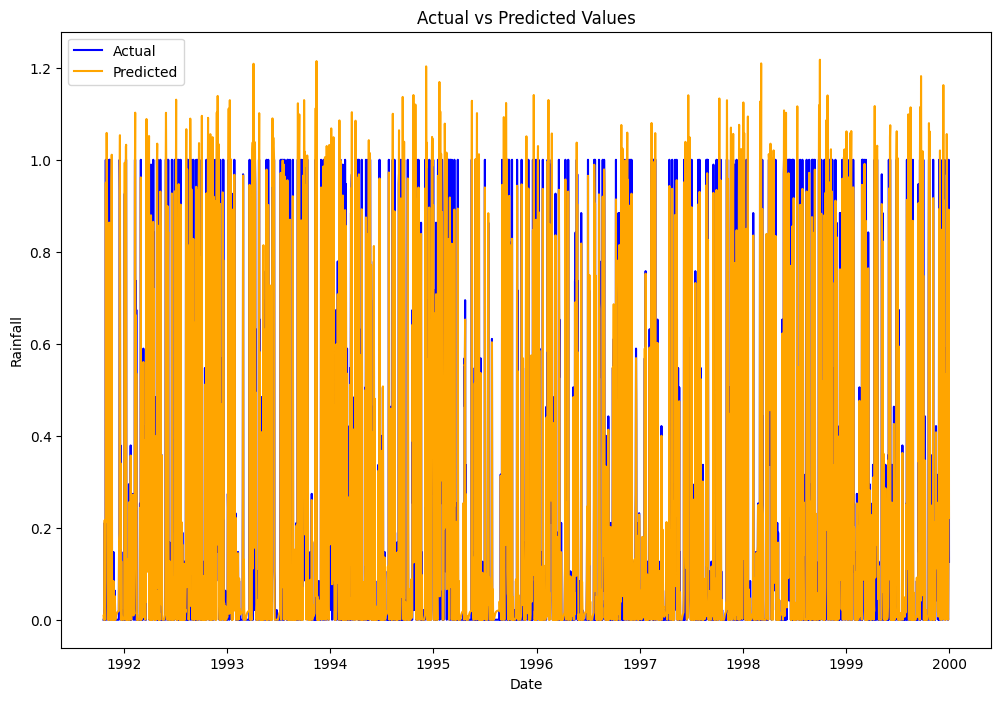

In [43]:
# Define features and target
x_rain = data[['rain_ewm_mean_for_3_days', 'rain_ewm_mean_for_7_days', 'rain_max', 'RAIN_LAST_3DAYS']]
y_rain = data['RAIN']

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_x, test_x = x_rain[:train_size], x_rain[train_size:]
train_y, test_y = y_rain[:train_size], y_rain[train_size:]

# Define the grid search parameters
p = range(0, 3)  # AR parameters
d = range(0, 2)  # Differencing parameters
q = range(0, 3)  # MA parameters
pdq = list(itertools.product(p, d, q))

# Grid search to find the best parameters
best_score, best_params = float("inf"), None
for param in pdq:
    try:
        model = ARIMA(train_y, exog=train_x, order=param)
        results = model.fit()
        
        # Prediction for evaluation
        forecast = results.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_x)
        
        # Model evaluation
        mae = mean_absolute_error(test_y, forecast)
        rmse = np.sqrt(mean_squared_error(test_y, forecast))
        score = rmse  # You can also use MAE or AIC as the metric
        
        if score < best_score:
            best_score = score
            best_params = param
    except Exception as e:
        print(f"Error with parameters {param}: {e}")
        continue

print(f'Best ARIMAX{best_params} RMSE={best_score}')

# Build and fit the best ARIMAX model with the best parameters
best_model = ARIMA(train_y, exog=train_x, order=best_params)
best_model_fit = best_model.fit()

# Forecast with the best model
forecast = best_model_fit.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_x)

# Clip negative values to zero
forecast = np.clip(forecast, 0, None)

# Model evaluation
mae = mean_absolute_error(test_y, forecast)
mse = mean_squared_error(test_y, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, forecast)
rrmse = rmse / np.mean(test_y)

# Print the error metrics
print(f'Final Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')
print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')

# Save the results and error metrics
results_df = pd.DataFrame({
    'Actual_Rain': test_y.values,       # Actual values
    'ARIMAX_Prediction': forecast       # Predicted values by ARIMAX model
})

# Save the predictions to a CSV file
predictions_output_file_path = os.path.join(file_path, 'arimax_predictions1.csv')
results_df.to_csv(predictions_output_file_path, index=False)
print(f'ARIMAX model predictions saved to {predictions_output_file_path}')

# Save the error metrics to a separate CSV file
error_metrics_df = pd.DataFrame({
    'Model': ['ARIMAX'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R^2': [r2],
    'RRMSE': [rrmse]
})

error_metrics_output_file_path = os.path.join(file_path, 'arimax_error_metrics.csv')
error_metrics_df.to_csv(error_metrics_output_file_path, index=False)
print(f'ARIMAX model error metrics saved to {error_metrics_output_file_path}')

# Result visualization
plt.figure(figsize=(12, 8))
plt.plot(test_y.index, test_y, label='Actual', color='blue')
plt.plot(test_y.index, forecast, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()
